# View Pic Du Midi Spectra : Compare good and bad


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in

https://github.com/sylvielsstfr/SpectractorAnaAtm19/blob/master/ana_20190215_HD116405_Filtre_None/ConvertSpectraToPandas.ipynb

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 30th 2020
- update : September 30th 2020 : 



# Import

In [51]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [52]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [53]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [54]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [55]:
from scipy import interpolate

# Functions

In [56]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [57]:
def GetSpectra(inputdir,inputfiles):
    """
    GetSpectra(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        #if idx>160 and idx<200:
        #    idx+=1
        #    continue
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [58]:
def GetSpectraFiltered(inputdir,inputfiles):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        if idx>160 and idx<200:
            idx+=1
            continue
        if idx>220 and idx<226:
            idx+=1
            continue
        if idx>275 and idx<295:
        #if idx>260 and idx<295:
            idx+=1
            continue
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [59]:
def ConvertToImage(all_df,WLMIN=350,WLMAX=1100):
    """
    ConvertToImage(all_df,WLMIN=350,WLMAX=1100)
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        fcn = interpolate.interp1d(df.wavelength,df.mag,bounds_error=False,fill_value=(0,0))
        mag_table[idx,:] = fcn(WL) 
        airm_table[idx]  = df.airmass[0]
        time_table[idx]  = df.time[0]
        
    return WL, mag_table, airm_table,time_table
       

In [60]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs time")
        plt.show()
     
    return 
     

In [61]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [62]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [63]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-30 23:06:22,990 MacBook-Pro-de-admin.local __main__[3236] INFO LA time:14:06:22
2020-09-30 23:06:22,992 MacBook-Pro-de-admin.local __main__[3236] INFO NY time:17:06:22
2020-09-30 23:06:22,993 MacBook-Pro-de-admin.local __main__[3236] INFO London time:22:06:22
2020-09-30 23:06:22,994 MacBook-Pro-de-admin.local __main__[3236] INFO Paris time:23:06:22
2020-09-30 23:06:22,999 MacBook-Pro-de-admin.local __main__[3236] INFO ************************ START *********************


In [64]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [65]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-30 23:06:23,028 MacBook-Pro-de-admin.local __main__[3236] INFO Configuration file : config/default.ini


In [66]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-09-30 23:06:23,039 MacBook-Pro-de-admin.local __main__[3236] INFO 1) Configuration


In [67]:
config_section = config.sections()

In [68]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [69]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [70]:
msg=f" Object observed {target}"
logger.info(msg)

2020-09-30 23:06:23,076 MacBook-Pro-de-admin.local __main__[3236] INFO  Object observed HD116405


In [71]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

# input files

## sed

In [72]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [73]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [74]:
sed_m=-2.5*np.log10(sed_f)

In [75]:
!ls 

ExtractThroughput.ipynb         ViewPDMData.ipynb
FitGPWithNoiseExample.ipynb     config
MLfit_bouguer_gp.ipynb          data
MLfit_bouguer_gp_out.csv        data_bad
MLfit_bouguer_linearfit.ipynb   data_clean
MLfit_bouguer_linearfit_out.csv data_clean_old
ViewGoodBadSpectra.ipynb


## data

In [76]:
inputdir_good="data_clean"
inputdir_bad="data_bad"

In [77]:
all_files_good = os.listdir(inputdir_good)
sorted_files_good=sorted(all_files_good)

In [78]:
all_files_bad = os.listdir(inputdir_bad)
sorted_files_bad=sorted(all_files_bad)

In [79]:
# search string
search_str="^"+f"{basefilename}.*csv$"

In [80]:
selected_files_good=[]
for file in sorted_files_good:
    if re.search(search_str,file):
        selected_files_good.append(file)

In [81]:
selected_files_bad=[]
for file in sorted_files_bad:
    if re.search(search_str,file):
        selected_files_bad.append(file)

In [82]:
NBFILES_GOOD=len(selected_files_good)
NBFILES_BAD=len(selected_files_bad)

In [83]:
msg=f" Number of good selected files is {NBFILES_GOOD}"
logger.info(msg)

2020-09-30 23:06:23,332 MacBook-Pro-de-admin.local __main__[3236] INFO  Number of good selected files is 276


In [84]:
msg=f" Number of bad selected files is {NBFILES_BAD}"
logger.info(msg)

2020-09-30 23:06:23,338 MacBook-Pro-de-admin.local __main__[3236] INFO  Number of bad selected files is 71


### Read all files

In [85]:
all_df_good=GetSpectra(inputdir_good,selected_files_good)
all_df_bad=GetSpectra(inputdir_bad,selected_files_bad)

In [86]:
NBFILES_GOOD=len(all_df_good)
NBFILES_BAD=len(all_df_bad)

In [87]:
NBFILES_BAD

70

In [88]:
NBFILES_GOOD

275

In [89]:
msg=f" Number of good spectra is {NBFILES_GOOD}"
logger.info(msg)

2020-09-30 23:06:26,621 MacBook-Pro-de-admin.local __main__[3236] INFO  Number of good spectra is 275


In [90]:
msg=f" Number of good spectra is {NBFILES_BAD}"
logger.info(msg)

2020-09-30 23:06:26,628 MacBook-Pro-de-admin.local __main__[3236] INFO  Number of good spectra is 70


(300.0, 1200.0)

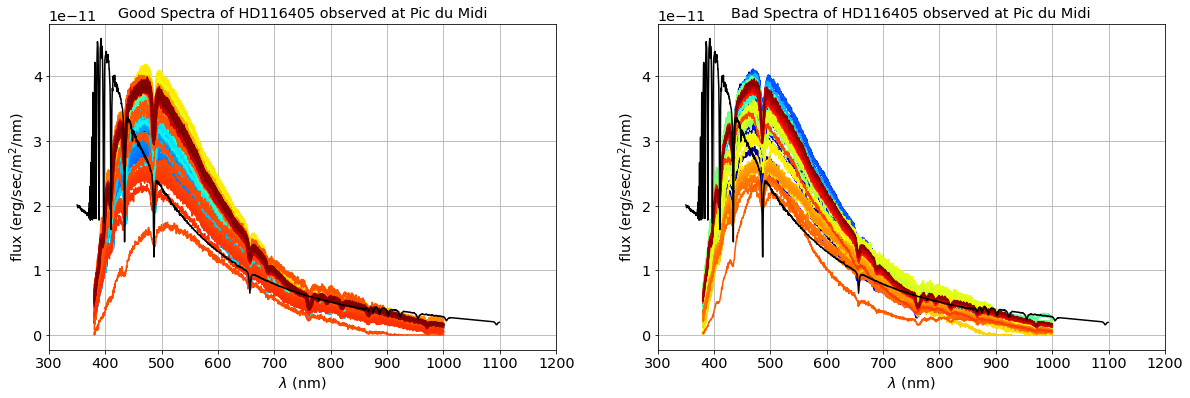

In [91]:
fig=plt.figure(figsize=(20,6))

ax=fig.add_subplot(121)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_GOOD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_GOOD), alpha=1)

for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]

    ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    #ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '.', color=all_colors[ifile],capsize = .01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Good Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)

ax=fig.add_subplot(122)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_BAD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_BAD), alpha=1)

for ifile in np.arange(NBFILES_BAD):
    the_df=all_df_bad[ifile]

    ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    #ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '.', color=all_colors[ifile],capsize = .01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Bad Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)

(26.0, 30.0)

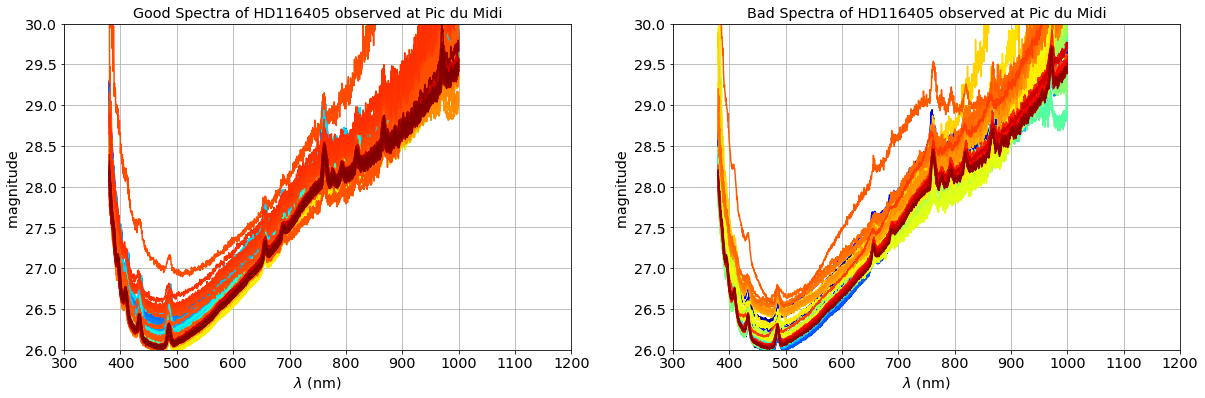

In [92]:
fig=plt.figure(figsize=(20,6))

ax=fig.add_subplot(121)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_GOOD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_GOOD), alpha=1)


for ifile in np.arange(NBFILES_GOOD):
    the_df=the_df=all_df_good[ifile]

    ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Good Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
#ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(26,30)

ax=fig.add_subplot(122)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_BAD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_BAD), alpha=1)


for ifile in np.arange(NBFILES_BAD):
    the_df=the_df=all_df_bad[ifile]

    ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Bad Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
#ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(26,30)

In [93]:
all_df_good[0]

,count,airmass,time,wavelength,flux,errflux,mag,errmag,abs,errabs,filename
0,0,1.545961,0.0,380.067586,1.906583e-12,4.487186e-14,29.299361,0.023535,28.776280,0.023535,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1,0,1.545961,0.0,380.511009,2.082932e-12,4.521747e-14,29.203312,0.021709,28.682771,0.021709,T1M_20190215_225550_730_HD116405_Filtre_None_b...
2,0,1.545961,0.0,380.954428,2.098480e-12,4.562320e-14,29.195238,0.021741,28.677220,0.021741,T1M_20190215_225550_730_HD116405_Filtre_None_b...
3,0,1.545961,0.0,381.397842,2.313665e-12,4.529898e-14,29.089249,0.019579,28.573740,0.019579,T1M_20190215_225550_730_HD116405_Filtre_None_b...
4,0,1.545961,0.0,381.841250,2.601964e-12,4.679267e-14,28.961747,0.017984,28.448731,0.017984,T1M_20190215_225550_730_HD116405_Filtre_None_b...
...,...,...,...,...,...,...,...,...,...,...,...
1411,0,1.545961,0.0,998.107996,1.436409e-12,1.802138e-14,29.606805,0.012546,29.596568,0.012546,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1412,0,1.545961,0.0,998.538774,1.459907e-12,1.812761e-14,29.589187,0.012417,29.578968,0.012417,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1413,0,1.545961,0.0,998.969540,1.475625e-12,1.820767e-14,29.577560,0.012339,29.567359,0.012339,T1M_20190215_225550_730_HD116405_Filtre_None_b...
1414,0,1.545961,0.0,999.400292,1.414770e-12,1.781298e-14,29.623285,0.012591,29.613101,0.012591,T1M_20190215_225550_730_HD116405_Filtre_None_b...


In [94]:
all_df_bad[0]

,count,airmass,time,wavelength,flux,errflux,mag,errmag,abs,errabs,filename
0,32,1.455956,0.31359,380.068620,4.162612e-12,4.902643e-14,28.451585,0.011778,27.958964,0.011778,T1M_20190215_231439_655_HD116405_Filtre_None_b...
1,32,1.455956,0.31359,380.511001,4.415153e-12,4.937681e-14,28.387636,0.011183,27.897400,0.011183,T1M_20190215_231439_655_HD116405_Filtre_None_b...
2,32,1.455956,0.31359,380.953377,4.751244e-12,5.019943e-14,28.307982,0.010566,27.820117,0.010566,T1M_20190215_231439_655_HD116405_Filtre_None_b...
3,32,1.455956,0.31359,381.395748,4.948708e-12,5.023987e-14,28.263770,0.010152,27.778263,0.010152,T1M_20190215_231439_655_HD116405_Filtre_None_b...
4,32,1.455956,0.31359,381.838115,5.062454e-12,5.096662e-14,28.239097,0.010068,27.755932,0.010068,T1M_20190215_231439_655_HD116405_Filtre_None_b...
...,...,...,...,...,...,...,...,...,...,...,...
1414,32,1.455956,0.31359,997.965960,1.629213e-12,1.832265e-14,29.470055,0.011246,29.460409,0.011246,T1M_20190215_231439_655_HD116405_Filtre_None_b...
1415,32,1.455956,0.31359,998.395725,1.483284e-12,1.810372e-14,29.571939,0.012205,29.562309,0.012205,T1M_20190215_231439_655_HD116405_Filtre_None_b...
1416,32,1.455956,0.31359,998.825477,1.479900e-12,1.796464e-14,29.574419,0.012139,29.564806,0.012139,T1M_20190215_231439_655_HD116405_Filtre_None_b...
1417,32,1.455956,0.31359,999.255216,1.599572e-12,1.824844e-14,29.489990,0.011408,29.480394,0.011408,T1M_20190215_231439_655_HD116405_Filtre_None_b...
